# LuGRE Data Analysis (AA272 Final Project)

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import re
import gnss_lib_py as glp
import pylupnt as pnt
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os
from pathlib import Path
from astropy.time import Time # datetime to TAI

outdir = Path().joinpath("data/new_lugre")
if not outdir.exists():
    os.makedirs(outdir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import LuGRE data

In [8]:
from src.lugre_parser import *

data_path = Path().joinpath("LuGRE Mission Data/L0/TLM/")
set_ids = get_unique_timestamps(data_path) # get all unique timestamps in the directory
# shrink set_ids to the ones on lunar surface
surf_ids = [set_id for set_id in set_ids if "_S_" in set_id]
print(len(surf_ids), "surface data sets found.")

# create output directories for every surf ids to save outputs
for set_id in surf_ids:
    dir = outdir.joinpath(set_id)
    if not dir.exists():
        os.makedirs(dir)

set_id = surf_ids[5]
# load data for a specific set_id
lugre_df = lugre_parser(data_path, set_id)

display(lugre_df['info'])

# set savepath for specific set_id
savepath = outdir.joinpath(set_id)

7 surface data sets found.


/Users/magi-nerv/Space-Specifically/Stanford/AA-272-GPS-Final/src/lugre_parser.py:62: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/Users/magi-nerv/Space-Specifically/Stanford/AA-272-GPS-Final/src/lugre_parser.py:62: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,date,time,duration,phase,opnumber,index
0,20250316,191448,03H,S,OP77,1


In [12]:
rxTimes, (rxTime_start, src_min), (rxTime_end, src_max) = get_unique_times(lugre_df, minmax=True)

print(f"Earliest time: {rxTime_start} from {src_min}")
print(f"Latest time: {rxTime_end} from {src_max}")

# convert to TAI
gps_week_start, sec_into_week_start = gps_seconds_to_gps_weeks(rxTime_start)
gps_week_end, sec_into_week_end = gps_seconds_to_gps_weeks(rxTime_end)
print(f"GPS Week: {gps_week_start}, Start sec into week: {sec_into_week_start}, End sec into week: {sec_into_week_end}")

utc_start = glp.gps_millis_to_datetime(rxTime_start*1000)
utc_end = glp.gps_millis_to_datetime(rxTime_end*1000)
# utc_end = pnt.gps_weeks_to_datetime(gps_week_end, round(sec_into_week_end))
print(f"UTC Start time: {utc_start}, UTC End time: {utc_end}")

tai_start = Time(utc_start, scale='utc').tai  # From Astropy
tai_end = Time(utc_start, scale='utc').tai  # From Astropy
# tai_start = pnt.datetime_to_tai(utc_start)
# tai_end = pnt.datetime_to_tai(utc_end)
# print(f"TAI Start time: {tai_start}, TAI End time: {tai_end}")

# tspan_tai = tai_start + np.linspace(0, tai_end - tai_start, 200)

Earliest time: 1426191726.63372 from acq
Latest time: 1426197553.43584 from acq
GPS Week: 2358, Start sec into week: 73326.63371992111, End sec into week: 79153.43583989143
UTC Start time: 2025-03-16 20:21:48.633720+00:00, UTC End time: 2025-03-16 21:58:55.435840+00:00


### Get receiver ECEF positions

In [ ]:
# get ECEF position of LuGRE receiver
rx_ecef = lugre_df['nav'][["posX", "posY", "posZ"]].to_numpy()
# conversion needs precise time from each ecef position from dataset
rxTime_nav = lugre_df['nav']["rxTime"]
rxTime_nav_tai = np.zeros_like(rxTime_nav)
for i, t in enumerate(rxTime_nav):
    # gps_week, sec_into_week = gps_seconds_to_gps_weeks(t)
    # rxTime_nav_dt = pnt.gps_weeks_to_datetime(gps_week, sec_into_week)
    rxTime_nav_dt = glp.gps_millis_to_datetime(t*1000)
    rxTime_nav_tai[i] = Time(rxTime_nav_dt, scale='utc').tai
    # rxTime_nav_tai[i] = pnt.datetime_to_tai(rxTime_nav_dt)

# convert to Moon PA frame to plot
rx_mpa = pnt.convert_frame(rxTime_nav_tai, rx_ecef, pnt.ECEF, pnt.MOON_PA)

### Plot ECEF positions

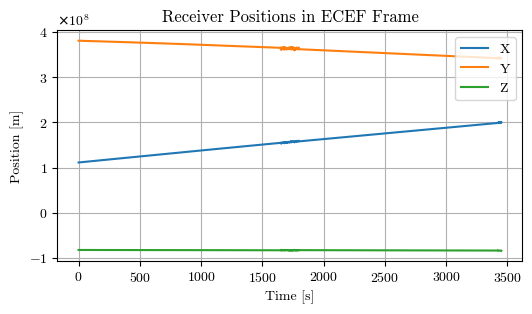

In [38]:
plt.figure(figsize=(6, 3))
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_ecef[:,0], label='X')
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_ecef[:,1], label='Y')
plt.plot(rxTime_nav_tai - rxTime_nav_tai[0], rx_ecef[:,2], label='Z')
plt.title("Receiver Positions in ECEF Frame")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.grid()
plt.legend()

# Export figure to pdf
plt.savefig(savepath.joinpath("NAV_ECEF.pdf"))
plt.show()

### Plot receiver positions in Moon PA (frame)

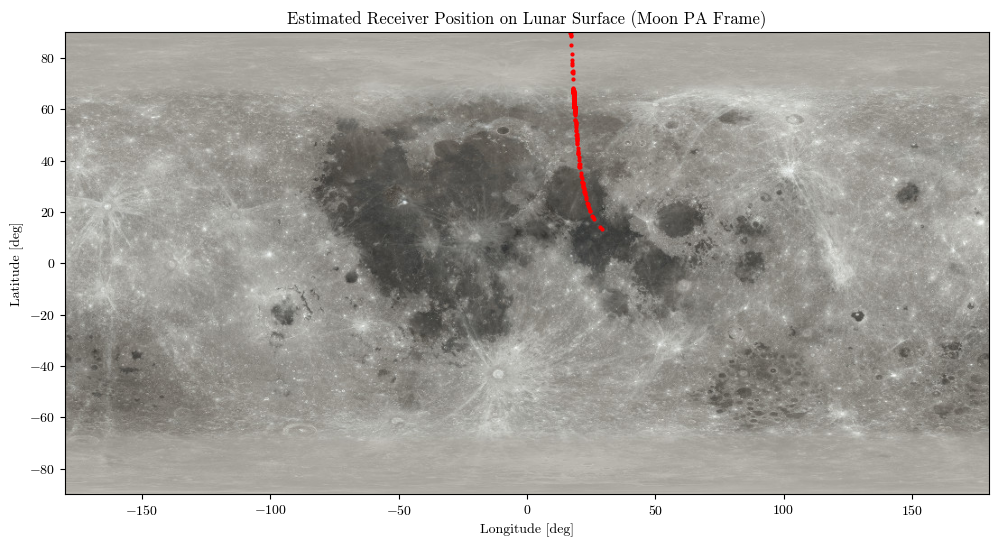

In [39]:
# plot receiver position in Moon PA frame (assert that all positions are on the Moon surface)
if lugre_df["info"]["phase"][0] == 'S':
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xlim(-180,180)
    ax.set_ylim(-90,90)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    ax.set_title("Estimated Receiver Position on Lunar Surface (Moon PA Frame)")

    # load Moon topography image
    img = plt.imread(pnt.LUPNT_DATA_PATH.joinpath("topo/moon_surface.jpeg"))
    # flip image vertically and horizontally
    img = img[::-1, ::-1]
    ax.imshow(img, extent=[-180,180,-90,90], alpha=1)

    figobj = [None] * len(rx_mpa)
    for i in range(len(rx_mpa)):
        lon_rad, lat_rad, _ = pnt.cartesian_to_geographic(rx_mpa[i, 0], rx_mpa[i, 1], rx_mpa[i, 2], pnt.R_MOON)
        lon = lon_rad * pnt.DEG
        lat = lat_rad * pnt.DEG
        figobj[i] = ax.plot(lon, lat, 'ro', markersize=2)
    
    # Export figure to pdf
    plt.savefig(savepath.joinpath("NAV_SurfPos.pdf"))

### Plot received C/N0 and corresponding satellite

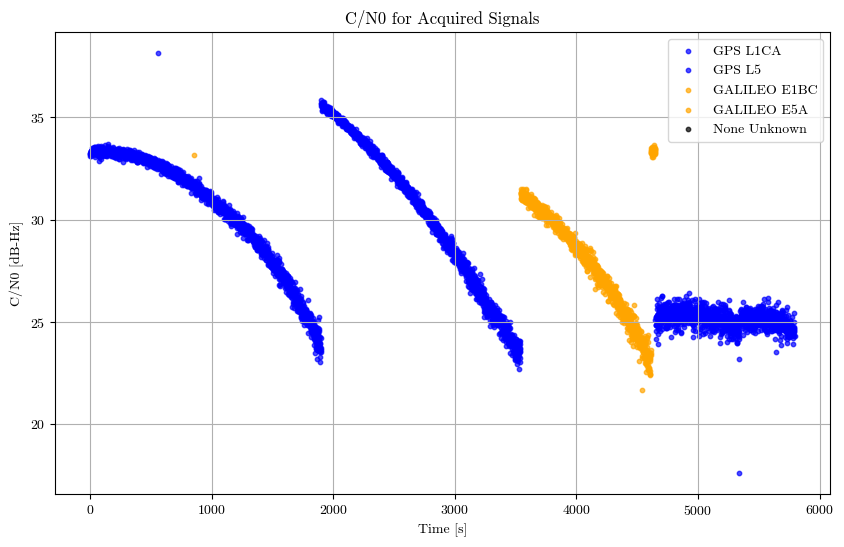

In [40]:
rxTime_acq = lugre_df['raw']["rxTime"].to_numpy()
cn0_acq = lugre_df['raw']["cn0"].to_numpy()
signal_ids = lugre_df['raw']["signalId"].to_numpy()
sv_ids = lugre_df['raw']["svid"].to_numpy()

unique_signal_ids = np.unique(signal_ids)

orbit_colors = {
    "G": "blue",  # GPS
    "E": "orange",  # GALILEO
    "C": "green",  # BEIDOU
    "R": "purple",  # GLONASS
    "J": "red",  # QZSS
}
legend_map = {
    "G": "GPS",
    "E": "GALILEO",
    "C": "BEIDOU",
    "R": "GLONASS",
    "J": "QZSS",
}

plt.figure(figsize=(10, 6))
for signal_id in unique_signal_ids:
    mask = signal_ids == signal_id
    (constellation, band) = get_const_band(signal_id)
    
    plt.scatter(
        rxTime_acq[mask] - rxTime_acq[0],
        cn0_acq[mask],
        label=f"{legend_map.get(constellation)} {band}",
        color=orbit_colors.get(constellation, "black"),
        alpha=0.7,
        s=10,
    )
plt.title("C/N0 for Acquired Signals")
plt.xlabel("Time [s]")
plt.ylabel("C/N0 [dB-Hz]")
plt.legend()
plt.grid()

# Export figure to pdf
plt.savefig(savepath.joinpath("ACQ_CN0.pdf"))
plt.show()

### Plot C/N0 by Signal ID

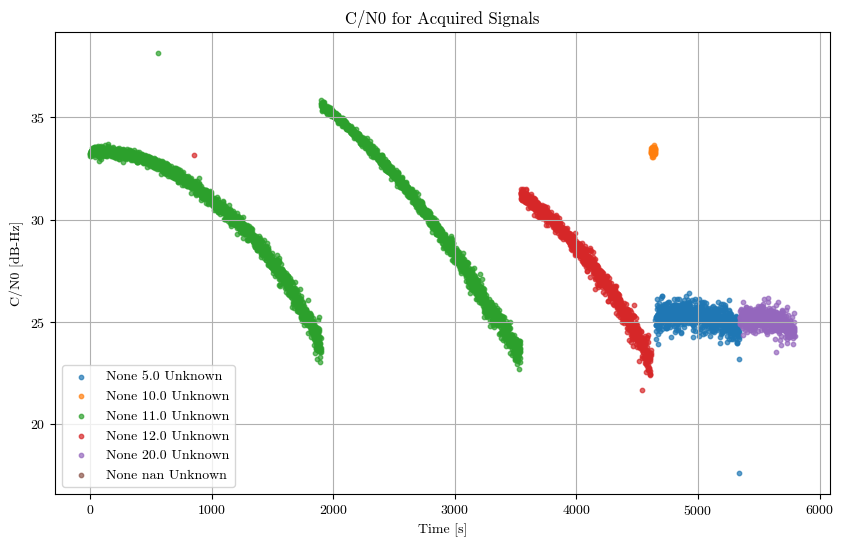

In [42]:
# plot C/N0 for acquired signals
unique_sv_ids = np.unique(sv_ids)
plt.figure(figsize=(10, 6))

for sv_id in unique_sv_ids:
    mask = sv_ids == sv_id
    (constellation, band) = get_const_band(signal_id)
    
    plt.scatter(
        rxTime_acq[mask] - rxTime_acq[0],
        cn0_acq[mask],
        label=f"{legend_map.get(constellation)} {sv_id} {band}",
        alpha=0.7,
        s=10,
    )
plt.title("C/N0 for Acquired Signals")
plt.xlabel("Time [s]")
plt.ylabel("C/N0 [dB-Hz]")
plt.legend()
plt.grid()

# Export figure to pdf
plt.savefig(savepath.joinpath("ACQ_CN0.pdf"))
plt.show()

## Get GNSS data

In [ ]:
# get precise ephemeris
sp3 = pnt.SP3Loader(target_dt=utc_start, sim_t=24*3600, dt_timesys=pnt.UTC)
print("SP3 satellites:", sp3.sats)
print("SP3 Epochs:", sp3.epochs)

SP3 file for GPS TIME: 2025-03-15 20:22:06.999999 already exists at /home/kura/LuPNT-private/output/gnss_files/sp3/COD0MGXFIN_20250740000_01D_05M_ORB.SP3. Skipping download.
SP3 file for GPS TIME: 2025-03-16 20:22:06.999999 already exists at /home/kura/LuPNT-private/output/gnss_files/sp3/COD0MGXFIN_20250750000_01D_05M_ORB.SP3. Skipping download.
SP3 file for GPS TIME: 2025-03-17 20:22:06.999999 already exists at /home/kura/LuPNT-private/output/gnss_files/sp3/COD0MGXFIN_20250760000_01D_05M_ORB.SP3. Skipping download.
SP3 file for GPS TIME: 2025-03-18 20:22:06.999999 already exists at /home/kura/LuPNT-private/output/gnss_files/sp3/COD0MGXFIN_20250770000_01D_05M_ORB.SP3. Skipping download.
SP3 satellites: ['C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C16', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C48', 'E02', 'E03', 'E04', 'E05', 

In [ ]:
# get all unique acquired satellites from acq data
keys = []
for index, row in lugre_df["acq"].iterrows():
    prn = int(row['svid'])
    signalId = int(row['signalId'])
    constellation, band = get_const_band(signalId)
    # generate key with leading zeros for prn
    keys.append(f"{constellation}{prn:02d}")

print("All satellites in ACQ data:", keys)
unique_sats = np.unique(keys)
print("Unique satellites in ACQ data:", unique_sats)

# check if all unique satellites are in SP3 data
for key in unique_sats:
    if key not in sp3.sats:
        print(f"Warning: Satellite {key} not found in SP3 data.")

All satellites in ACQ data: ['G11', 'E23', 'E10', 'E11', 'E24', 'E04', 'E06', 'E12', 'E31', 'E10', 'E23', 'E33', 'E11', 'E12', 'E31', 'G20', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E06', 'E12', 'E31', 'E33', 'E11', 'E12', 'E31', 'E10', 'E23', 'E04', 'E06', 'E12', 'E31', 'E10', 'E23', 'E33', 'E11', 'E24', 'E12', 'E31', 'E23', 'E33', 'E04', 'E06', 'E12', 'E31', 'E10', 'E33', 'E24', 'E12', 'E31', 'E10', 'E23', 'E33', 'E11', 'E04', 'E06', 'E31', 'E10', 'E23', 'E33', 'E24', 'E31', 'E10', 'E23', 'E33', 'E04', 'E06', 'E31', 'E10', 'E23', 'E33', 'E11', 'E24', 'E31', 'E10', 'E23', 'E04', 'E06', 'E31', 'E10', 'E23', 'E33', 'E11', 'E24', 'E10', 'E23', 'E06', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E10', 'E23', 'E33', 'E06', 'E10', 'E23', 'G19', 'E11', 'E24', 'E04', 'E23', 'E06', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E10', 'E23', 'E33', 'E11', 'E06', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E10', 'E11', 'E06', 'E10', 'E23', 'E33', 'E24', 'E10', 'E23', 'E33', 'E11', 'E24', 'E04', 'E06'

In [ ]:
# Example: Get position, velocity, and clock bias for a specific satellite at a target time
constellation = "E"  # 'G' for GPS, 'R' for GLONASS, 'E' for Galileo, etc.
prn = 2  # PRN number of the satellite

rv_prop, clock_bias = sp3.get_posvelclock(
    constellation, prn, tai_start, out_frame=pnt.ECEF, propagate=True
)
rv_interp, clock_bias_interp = sp3.get_posvelclock(
    constellation, prn, tai_start, out_frame=pnt.ECEF, propagate=False
)

print("RV Propagation for {0}{1:02d} at target TAI:".format(constellation, prn))
print("Position   [m]     : ", rv_prop[:3])
print("Velocity   [m/s]   : ", rv_prop[3:])
print("Clock Bias [micros] : ", clock_bias * 1e6)
print(" ")
print("RV Interpolation for {0}{1:02d} at target TAI:".format(constellation, prn))
print("Position   [m]     : ", rv_interp[:3])
print("Velocity   [m/s]   : ", rv_interp[3:])
print("Clock Bias [micros] : ", clock_bias_interp * 1e6)


RV Propagation for E02 at target TAI:
Position   [m]     :  [-12353384.45553382  26886345.58251425    407391.34240429]
Velocity   [m/s]   :  [  76.84521831  -11.69658829 3015.59825224]
Clock Bias [micros] :  205.07897703400593
 
RV Interpolation for E02 at target TAI:
Position   [m]     :  [-12353384.2311654   26886345.1860018     407391.32482878]
Velocity   [m/s]   :  [  76.84781466  -11.7007754  3015.59802814]
Clock Bias [micros] :  205.0789802556213


In [ ]:
# compute SP3 orbits and clock biases for all satellites
rv_sats_sp3, clock_sats_sp3, sats_list_sp3 = sp3.get_posvelclock_all(
    tspan_tai, out_frame=pnt.ECI, sats_list = unique_sats,propagate=False
)

### Plot orbits

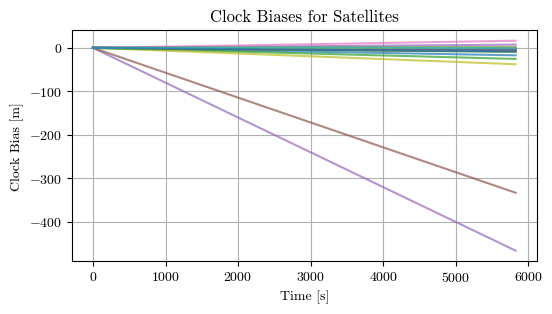

In [ ]:
# plot orbits and clock biases
fig = go.Figure()

pnt.plot.plot_body(fig, pnt.EARTH, size_factor=5)
# get position of moon
e2m_eci = pnt.get_body_pos_vel(tspan_tai, pnt.EARTH, pnt.MOON, pnt.ECI)

orbit_colors = {
    "G": "blue",  # GPS
    "E": "orange",  # GALILEO
    "C": "green",  # BEIDOU
    "R": "purple",  # GLONASS
    "J": "red",  # QZSS
}

gnss_consts = ["G", "E", "C", "R", "J"]  # GPS, GALILEO, BEIDOU, QZSS

# gnss
for gnss_const in gnss_consts:
    sat_idx = [i for i, sat in enumerate(unique_sats) if sat.startswith(gnss_const)]
    pnt.plot.plot_orbits(
        fig, 
        rv_sats_sp3[sat_idx, :, :], 
        t=0, 
        color=orbit_colors[gnss_const]
    )
# plot moon direction
pnt.plot.plot_arrow3(fig, np.zeros(3), e2m_eci[:, :3]/10, length = 1.5, tip = 0.2, color='gray')
pnt.plot.set_view(fig, -80, 20, 2.5)
fig.update_layout(showlegend=True, width=400, height=400)
fig.show()

# plot clock biases
Cms = 299792458  # Convert clock bias from seconds to meters
plt.figure(figsize=(6, 3))
for i, sat in enumerate(sats_list_sp3):
    plt.plot(
        tspan_tai - tspan_tai[0],
        (clock_sats_sp3[i] - clock_sats_sp3[i][0]) * Cms,
        label=f"Satellite {sat}",
        alpha=0.7,
    )
plt.title("Clock Biases for Satellites")
plt.xlabel("Time [s]")
plt.ylabel("Clock Bias [m]")
plt.grid()
plt.show()

## Calculate C/N0